In [16]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
import pandas as pd
import math

In [17]:
##########################################################################################################

def filterinitialset (filename, headername = "vibrational level v\Temperature(K)",  \
    factor = 1.0, normalize = False):

    dfin = pd.read_excel(filename)

    #print(dfin)
    
    dfdict = {}
    
    tempvalues = list(dfin.columns[1:])
    vibvalues = list(dfin[headername].values)

    min = float("inf")
    max = float("-inf")
    for c in dfin.columns:
        dfdict[c] = []
        if c == headername:
            dfdict[c] = list(dfin[c].values)
        else:
            for v in dfin[c].values:
                val = factor*v
                if val > max:
                    max = val
                if val < min:
                    min = val

    for c in dfin.columns:
        if c != headername:
            for v in dfin[c].values:
                val = factor*v
                valp = (val - min) / (max - min)
                if normalize:
                    dfdict[c].append(valp)
                else:
                    dfdict[c].append(val)

    df = pd.DataFrame.from_dict(dfdict)

    return df, vibvalues, tempvalues

##############################################################################

def plotfull3dcurve (df, vib_values, temp_values):

    y = []
    x = []
    for t in temp_values:
        for idx in range(len(vib_values)):
            x.append([float(t), float(vib_values[idx])])
            y.append(df[t].values[idx])

    X = np.array(x)
    Y = np.array(y)

    xdim = len(temp_values)
    ydim = len(vib_values)

    Xp = np.zeros((xdim, ydim), dtype=float)
    Yp = np.zeros((xdim, ydim), dtype=float)
    Zp = np.zeros((xdim, ydim), dtype=float)
    for xidx in range(xdim):
        t = temp_values[xidx]
        for yidx in range(ydim):
            v =  vib_values[yidx]
            Xp[xidx, yidx] = float(t)
            Yp[xidx, yidx] = float(v)
            Zp[xidx, yidx] = df[t].values[yidx]

    #fig = plt.figure(figsize=(10,8))
    fig = plt.figure(figsize=plt.figaspect(2.))
    plt.gcf().set_size_inches(40, 30)
    ax = fig.add_subplot(2,1,1, projection='3d')
    surf = ax.plot_surface(Xp, Yp, Zp, rstride=1, cstride=1, cmap='jet', linewidth=0, antialiased=False)
    plt.show()

##########################################################################################################3

def fitusingscikitl (train_x, train_y):
    #kernel = gp.kernels.ConstantKernel(1.0, (1e-5, 1e5))* gp.kernels.RBF(length_scale=1)
    kernel = gp.kernels.ConstantKernel(1.0, (1e-3, 1e3)) * gp.kernels.RBF([5,5], (1e-2, 1e2))
    model = gp.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=50, \
        normalize_y=False)
    print("Start training ")
    model.fit(train_x, train_y)
    print("Done ")

    return model

##########################################################################################################


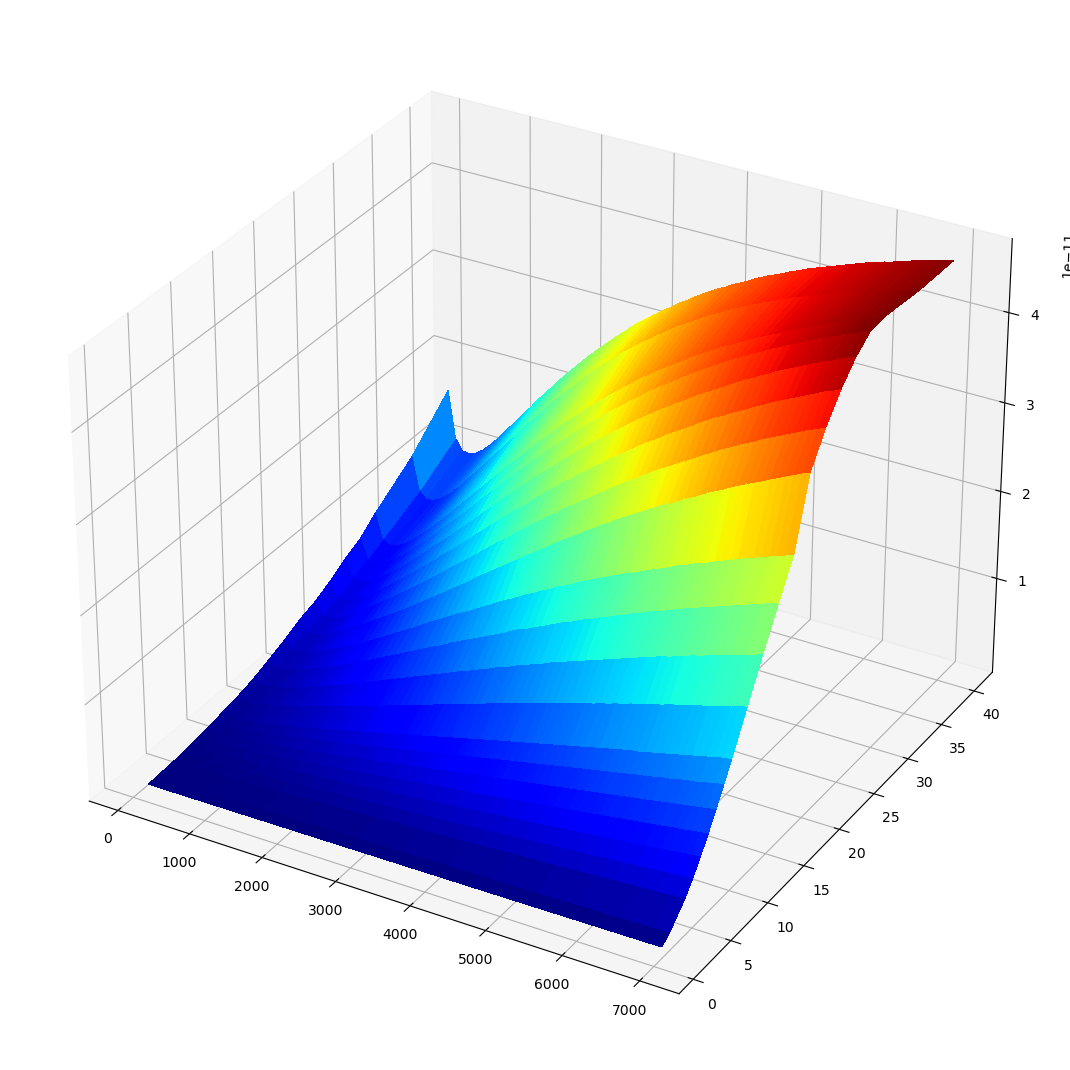

In [18]:
filename = "N2N2_dataset.xls"
df, vib_values , temp_values = filterinitialset (filename)
plotfull3dcurve (df, vib_values, temp_values)

In [19]:
maxt = max(temp_values)
mint = min(temp_values)

minv = min(vib_values)
maxv = max(vib_values)

train_xy = []
train_z = []

maxz = float("-inf")
minz = float("+inf")

for tidx, t in enumerate(temp_values):
    for vidx, v in enumerate(vib_values):
        zval = df[t].values[vidx]

        if zval < minz:
            minz = zval
        elif zval > maxz:
            maxz = zval

for tidx, t in enumerate(temp_values):
    tnorm = (t - mint)/(maxt - mint)
    #print(t, " ", tnorm)

    for vidx, v in enumerate(vib_values):
        vnorm  = (v - minv)/(maxv - minv)
    
        train_xy.append([tnorm, vnorm])
        
        z = df[t].values[vidx]
        znorm = (z - minz)/(maxz - minz)
        train_z.append(znorm)

        #print("  %10.2f %10.7f ==> %10.7e %10.7f"%(v, vnorm, z, znorm ))

train_xy = np.asarray(train_xy)
train_z = np.asarray(train_z)

"""
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for i in range(train_z.shape[0]):
    x = train_xy[i,0]
    y = train_xy[i,1]
    z = train_z[i]
    ax.scatter(x, y, z, marker="o", color="r")

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.gcf().set_size_inches(20, 15)

plt.show()
"""

'\nfig = plt.figure()\nax = fig.add_subplot(projection=\'3d\')\n\nfor i in range(train_z.shape[0]):\n    x = train_xy[i,0]\n    y = train_xy[i,1]\n    z = train_z[i]\n    ax.scatter(x, y, z, marker="o", color="r")\n\nax.set_xlabel(\'X Label\')\nax.set_ylabel(\'Y Label\')\nax.set_zlabel(\'Z Label\')\nplt.gcf().set_size_inches(20, 15)\n\nplt.show()\n'

In [20]:
def build_model ():
    model = keras.Sequential()
    model.add(keras.layers.Dense(units = 2, activation = 'linear', input_shape=[2]))
    model.add(keras.layers.Dense(units = 32, activation = 'relu'))
    model.add(keras.layers.Dense(units = 64, activation = 'relu'))
    model.add(keras.layers.Dense(units = 128, activation = 'relu'))
    model.add(keras.layers.Dense(units = 32, activation = 'relu'))
    #model.add(keras.layers.Dense(units = 16, activation = 'relu'))
    model.add(keras.layers.Dense(units = 1, activation = 'linear'))
    model.compile(loss='mse', optimizer="adam", metrics='mse')
    #model.summary()

    return model

In [21]:

from sklearn.model_selection import train_test_split

usevalidation = False
history = None
nepochs = 100

model = build_model()

if usevalidation:
    X_train, X_val, y_train, y_val \
            = train_test_split(train_xy, train_z, \
            test_size=0.33, random_state=42)

    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=nepochs, verbose=0)
else:
    history = model.fit(train_xy, train_z, epochs=nepochs, verbose=0)

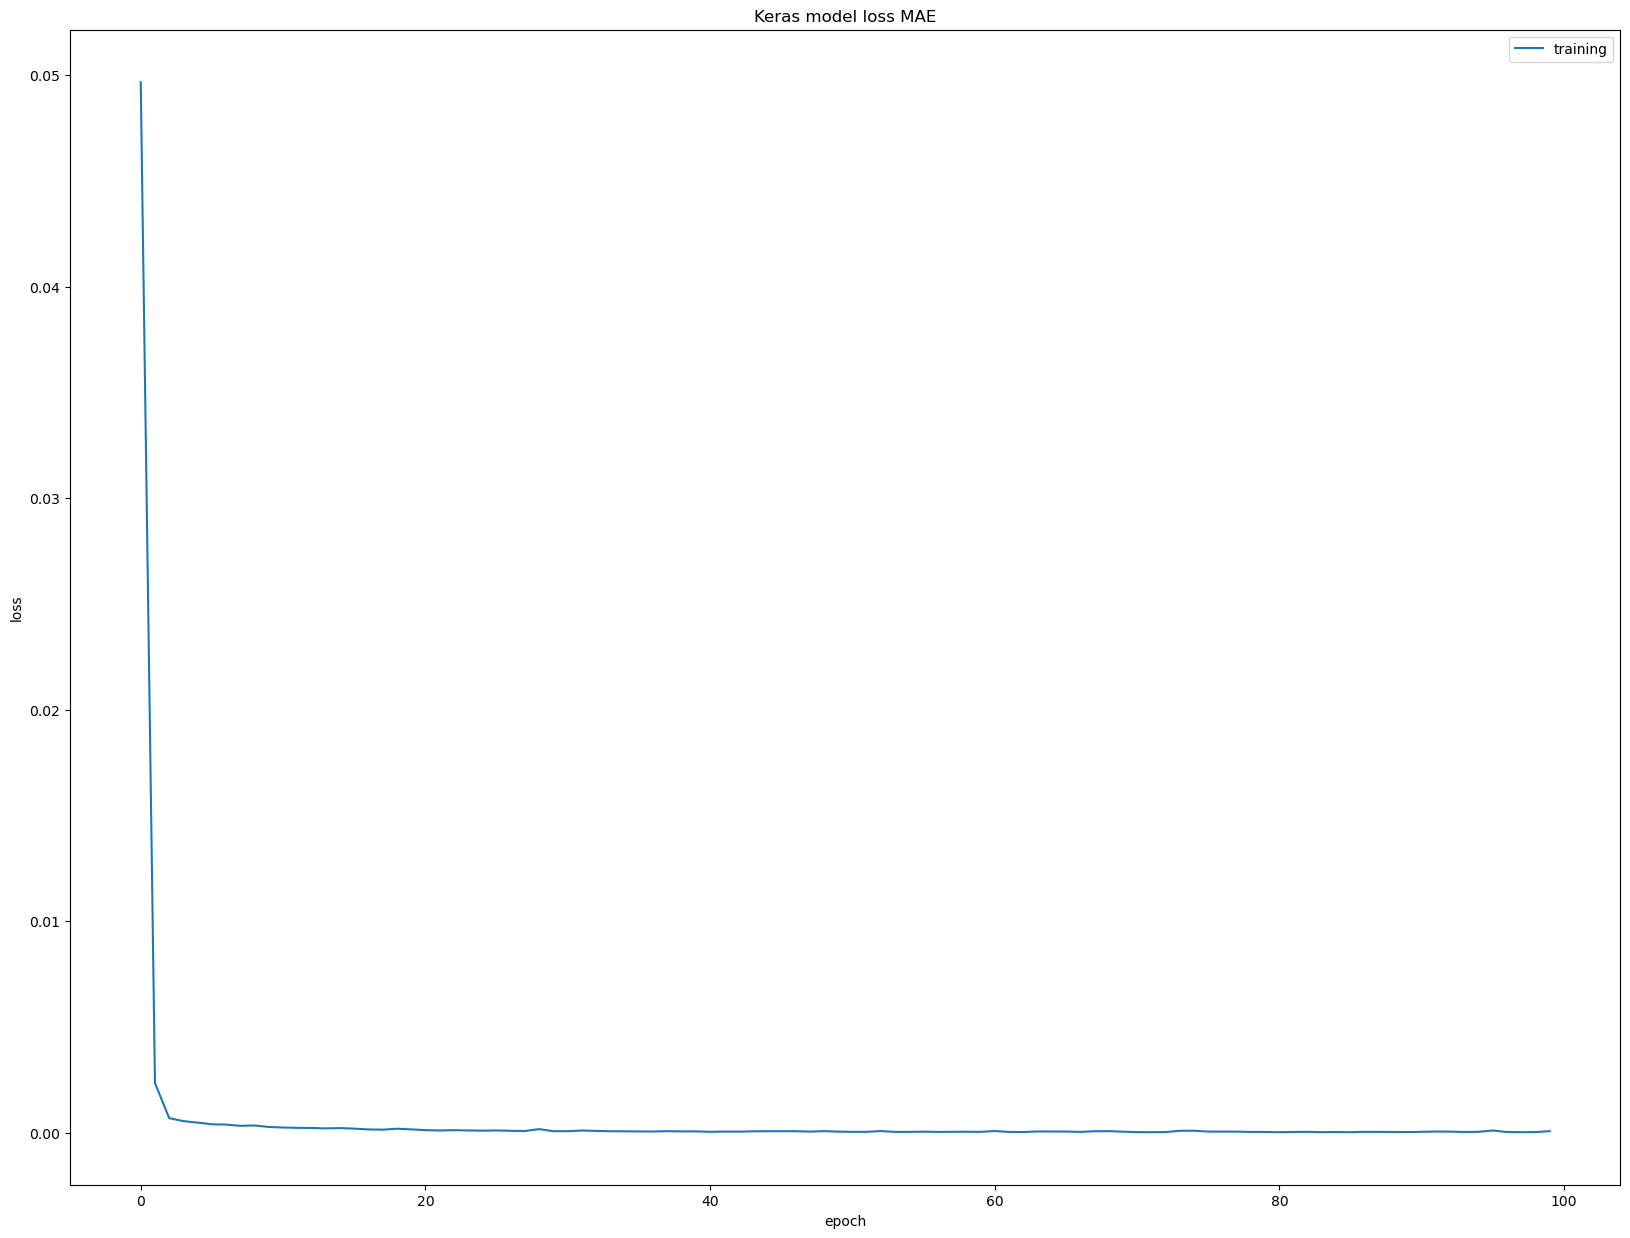

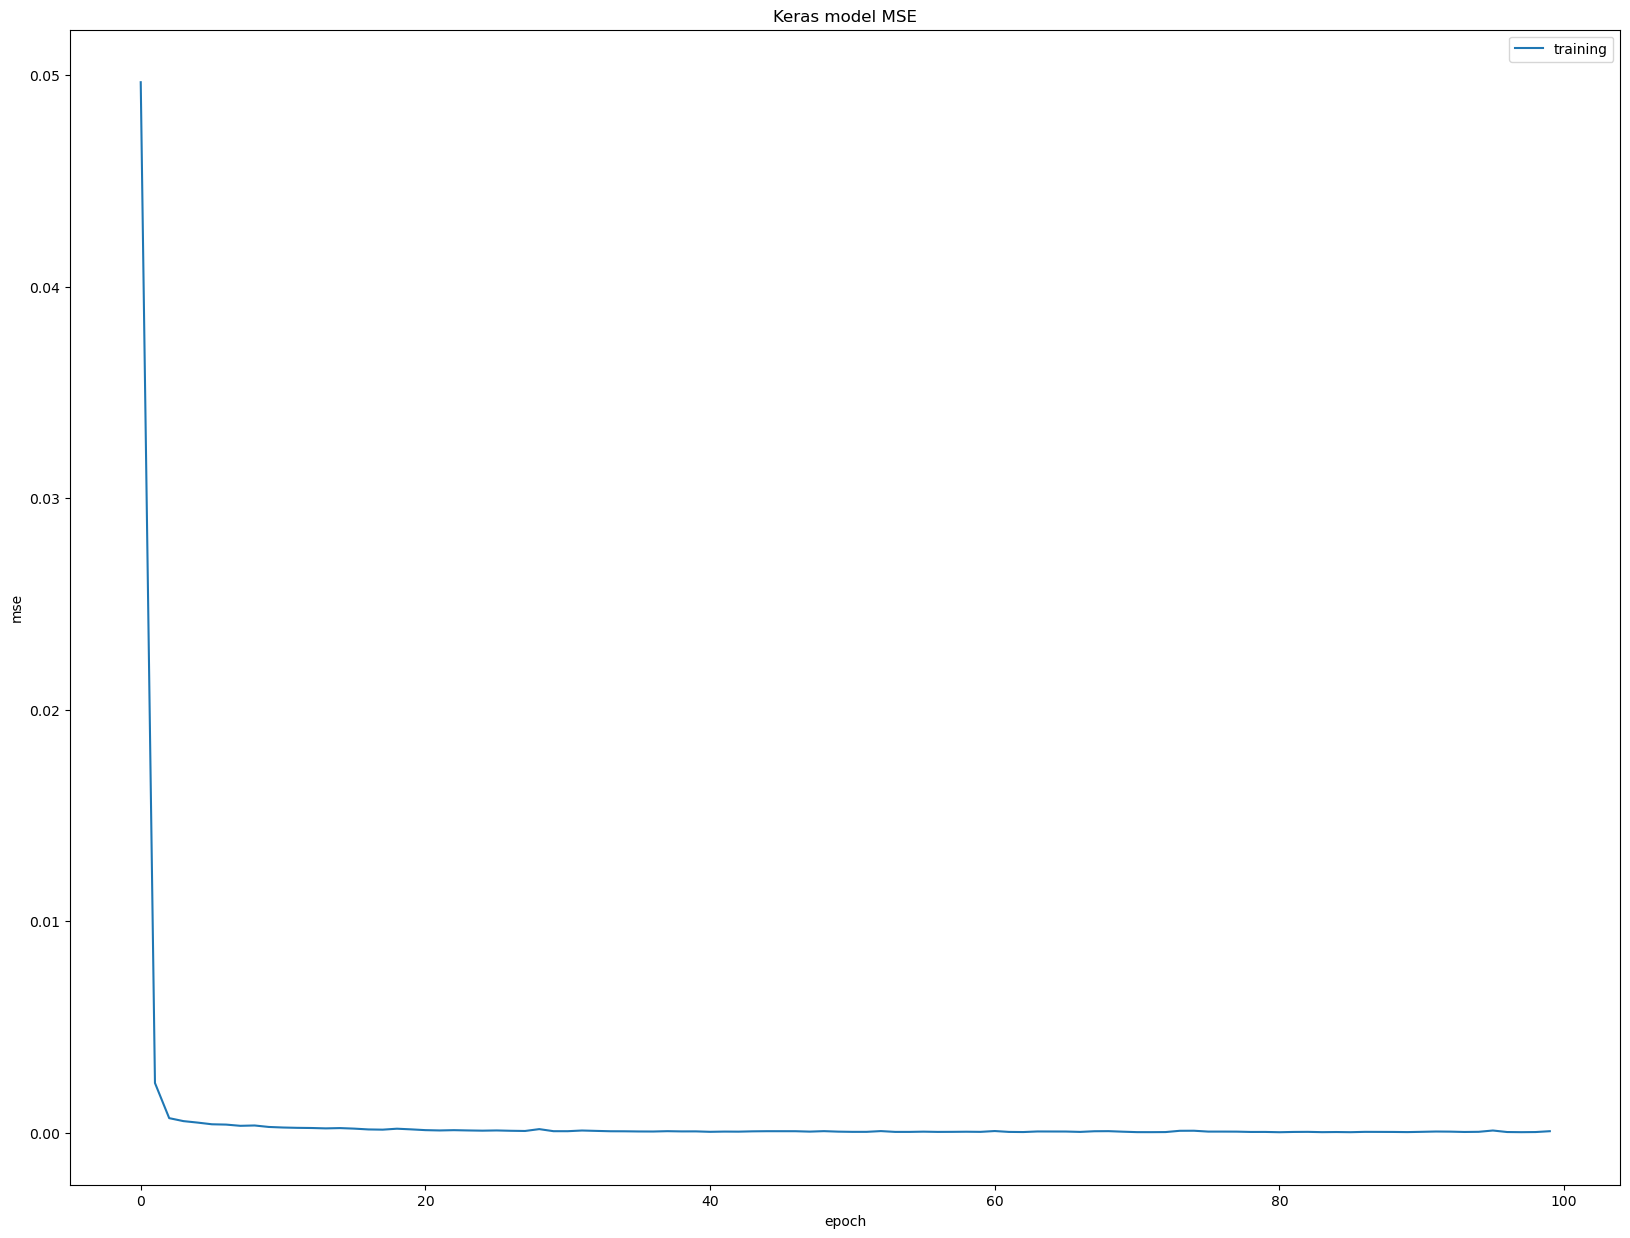

In [22]:
plt.title('Keras model loss MAE')
plt.plot(history.history['loss'])
if usevalidation:
    plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.gcf().set_size_inches(20, 15)

plt.show()

plt.clf()
plt.title('Keras model MSE')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.plot(history.history['mse'])
if usevalidation:
    plt.plot(history.history['val_mse'])
plt.legend(['training', 'validation'], loc='upper right')
plt.gcf().set_size_inches(20, 15)

plt.show()

In [23]:
# Compute the output 
test_xy = []

test_xy = train_xy

z_pred = model.predict(train_xy)

46/46 [==============================] - 0s 7ms/step


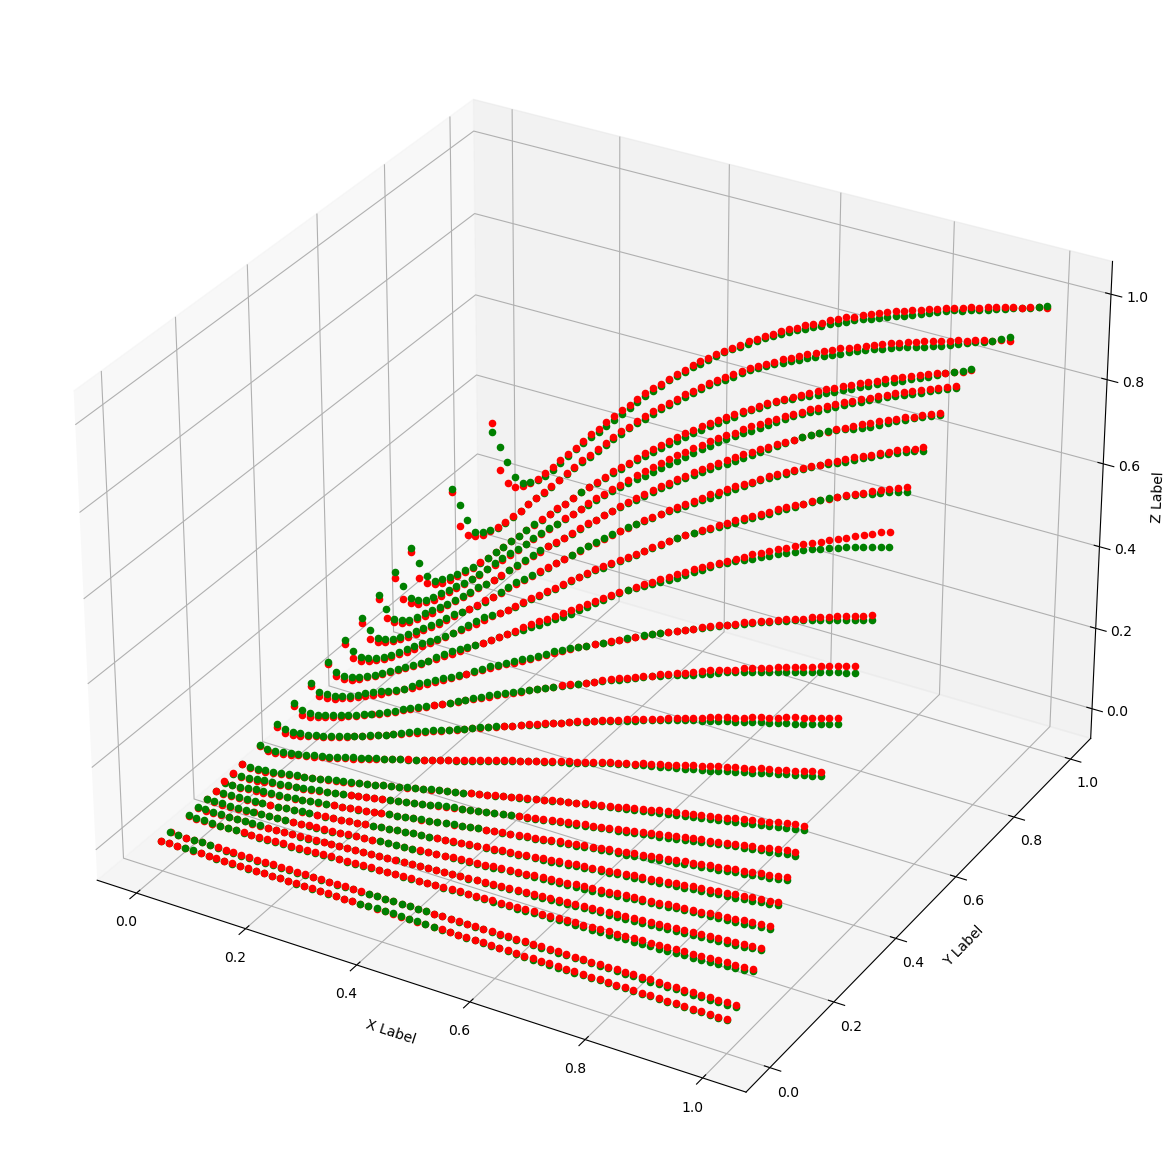

In [24]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for i in range(train_z.shape[0]):
    x = train_xy[i,0]
    y = train_xy[i,1]
    z = train_z[i]
    ax.scatter(x, y, z, marker="o", color="r")

for i in range(train_z.shape[0]):
    x = test_xy[i,0]
    y = test_xy[i,1]
    z = z_pred[i]
    ax.scatter(x, y, z, marker="o", color="g")

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.gcf().set_size_inches(20, 15)

plt.show()

In [25]:
for i in range(train_z.shape[0]):
    x = train_xy[i,0]
    y = train_xy[i,1]
    z = train_z[i]
    zpred = z_pred[i]

    diff = 100.0*(math.fabs(zpred-z) / (math.fabs(zpred+z)/2))

    if diff > 1.0e-2:
        print("%6.2f, %10.7e , %10.7e"%(diff, z, zpred))

 39.20, 7.2209527e-05 , 4.8540533e-05
100.03, 8.8987622e-04 , 2.6707873e-03
 57.70, 3.5297716e-03 , 6.3922778e-03
 43.45, 5.1226288e-03 , 7.9664141e-03
  9.97, 7.6712003e-03 , 8.4761456e-03
 13.95, 1.0432153e-02 , 9.0719014e-03
 23.26, 1.4318724e-02 , 1.1334643e-02
 13.94, 1.7525677e-02 , 1.5242159e-02
  6.14, 2.1560915e-02 , 2.0276539e-02
  9.93, 2.8994249e-02 , 3.2024600e-02
 16.19, 3.9613297e-02 , 4.6593830e-02
 12.36, 5.4692345e-02 , 6.1896756e-02
  9.41, 6.9983774e-02 , 7.6890677e-02
  4.75, 8.8885680e-02 , 9.3206540e-02
 10.06, 1.0162854e-01 , 1.1239477e-01
  9.28, 1.2095520e-01 , 1.3272375e-01
  6.37, 1.4516663e-01 , 1.5471429e-01
  8.75, 1.6406854e-01 , 1.7908549e-01
  4.62, 1.9528854e-01 , 2.0451438e-01
  2.69, 2.6091426e-01 , 2.6801586e-01
  6.63, 3.5223807e-01 , 3.2962489e-01
200.00, 0.0000000e+00 , -8.3699077e-04
 76.00, 6.4563812e-04 , 1.4371052e-03
 70.02, 2.7652001e-03 , 5.7440922e-03
 58.66, 4.1244383e-03 , 7.5476393e-03
 44.53, 6.0571050e-03 , 9.5269531e-03
 25.00, 8.0

In [26]:
def get_train_and_test_rmt (temp_values, vib_values, df, \
    removetemps=[]):

    maxt = max(temp_values)
    mint = min(temp_values)

    minv = min(vib_values)
    maxv = max(vib_values)

    train_xy = []
    train_z = []

    test_xy = []
    test_z = []

    maxz = float("-inf")
    minz = float("+inf")

    for tidx, t in enumerate(temp_values):
        for vidx, v in enumerate(vib_values):
            zval = df[t].values[vidx]

            if zval < minz:
                minz = zval
            elif zval > maxz:
                maxz = zval

    for t in temp_values:
        if t not in removetemps:
            tnorm = (t - mint)/(maxt - mint)

            for vidx, v in enumerate(vib_values):
                vnorm  = (v - minv)/(maxv - minv)
                train_xy.append([tnorm, vnorm])
        
                z = df[t].values[vidx]
                znorm = (z - minz)/(maxz - minz)
                train_z.append(znorm)
        else:
            tnorm = (t - mint)/(maxt - mint)
            for vidx, v in enumerate(vib_values):
                vnorm  = (v - minv)/(maxv - minv)
                test_xy.append([tnorm, vnorm])

                z = df[t].values[vidx]
                znorm = (z - minz)/(maxz - minz)
                test_z.append(znorm)


    train_xy = np.asarray(train_xy)
    train_z = np.asarray(train_z)

    test_xy = np.asarray(test_xy)
    test_z = np.asarray(test_z)

    return train_xy, train_z, test_xy, test_z

def get_train_and_test_rmv (temp_values, vib_values, df, \
    removevibs=[]):

    maxt = max(temp_values)
    mint = min(temp_values)

    minv = min(vib_values)
    maxv = max(vib_values)

    train_xy = []
    train_z = []

    test_xy = []
    test_z = []

    maxz = float("-inf")
    minz = float("+inf")

    for tidx, t in enumerate(temp_values):
        for vidx, v in enumerate(vib_values):
            zval = df[t].values[vidx]

            if zval < minz:
                minz = zval
            elif zval > maxz:
                maxz = zval

    for t in temp_values:
        tnorm = (t - mint)/(maxt - mint)

        for vidx, v in enumerate(vib_values):
            if v not in removevibs:
                vnorm  = (v - minv)/(maxv - minv)
                train_xy.append([tnorm, vnorm])
        
                z = df[t].values[vidx]
                znorm = (z - minz)/(maxz - minz)
                train_z.append(znorm)
            else:
                vnorm  = (v - minv)/(maxv - minv)
                test_xy.append([tnorm, vnorm])

                z = df[t].values[vidx]
                znorm = (z - minz)/(maxz - minz)
                test_z.append(znorm)

    train_xy = np.asarray(train_xy)
    train_z = np.asarray(train_z)

    test_xy = np.asarray(test_xy)
    test_z = np.asarray(test_z)

    return train_xy, train_z, test_xy, test_z

import random 

def get_train_and_test_random (temp_values, vib_values, df, \
    perc):

    maxt = max(temp_values)
    mint = min(temp_values)

    minv = min(vib_values)
    maxv = max(vib_values)

    train_xy = []
    train_z = []

    test_xy = []
    test_z = []

    maxz = float("-inf")
    minz = float("+inf")

    totnumber = 0;
    for t in temp_values:
        for vidx, v in enumerate(vib_values):
            zval = df[t].values[vidx]

            totnumber += 1

            if zval < minz:
                minz = zval
            elif zval > maxz:
                maxz = zval

    for t in temp_values:
        tnorm = (t - mint)/(maxt - mint)
        for vidx, v in enumerate(vib_values):
            rv = random.uniform(0.0, float(totnumber))
            #print(rv, perc*float(totnumber))
            if rv > (perc*float(totnumber)):
                vnorm  = (v - minv)/(maxv - minv)
                train_xy.append([tnorm, vnorm])
        
                z = df[t].values[vidx]
                znorm = (z - minz)/(maxz - minz)
                train_z.append(znorm)
            else:
                vnorm  = (v - minv)/(maxv - minv)
                test_xy.append([tnorm, vnorm])

                z = df[t].values[vidx]
                znorm = (z - minz)/(maxz - minz)
                test_z.append(znorm)


    train_xy = np.asarray(train_xy)
    train_z = np.asarray(train_z)

    test_xy = np.asarray(test_xy)
    test_z = np.asarray(test_z)

    return train_xy, train_z, test_xy, test_z

In [29]:
# remove temp
overallmse = 0.0
tot = 0

fp = open("removingtemp_nn.txt", "w")
for trm in temp_values:
    temp_torm = [trm]

    train_xy, train_z, test_xy, test_z = get_train_and_test_rmt (temp_values, vib_values, \
        df, temp_torm)

    modelt = build_model()

    history = None
    nepochs = 100
    history = modelt.fit(train_xy, train_z, epochs=nepochs, verbose=0)

    z_pred = modelt.predict(train_xy)

    mse = 0.0
    for i in range(test_z.shape[0]):
        x = test_xy[i,0]
        y = test_xy[i,1]
        z = test_z[i]
        zpred = z_pred[i]

        mse += (zpred-z)**2
        overallmse += (zpred-z)**2
        tot += 1

        print("%10.7f , %10.7f , %10.7f , %10.7f"%(z, y, z, zpred), file=fp)

    print("Removed ", trm, " MSE ", mse/float(i), file=fp, flush=True)
    print("Removed ", trm, " MSE ", mse/float(i))

print("Overall MSE ", overallmse/float(tot), file=fp)

46/46 [==============================] - 0s 3ms/step
Removed  100  MSE  [0.00232137]
46/46 [==============================] - 0s 5ms/step
Removed  200  MSE  [3.1318592e-05]
46/46 [==============================] - 0s 3ms/step
Removed  300  MSE  [0.00116358]
46/46 [==============================] - 0s 5ms/step
Removed  400  MSE  [0.00040665]
46/46 [==============================] - 0s 4ms/step
Removed  500  MSE  [8.7773355e-05]
46/46 [==============================] - 0s 5ms/step
Removed  600  MSE  [8.440755e-05]
46/46 [==============================] - 0s 6ms/step
Removed  700  MSE  [0.00040183]
46/46 [==============================] - 0s 5ms/step
Removed  800  MSE  [0.00038317]
46/46 [==============================] - 0s 3ms/step
Removed  900  MSE  [0.00116468]
46/46 [==============================] - 0s 6ms/step
Removed  1000  MSE  [0.00167065]
46/46 [==============================] - 0s 5ms/step
Removed  1100  MSE  [0.00336338]
46/46 [==============================] - 0s 6ms/step
Re

In [30]:
overallmse = 0.0
tot = 0
fp = open("removingvib_nn.txt", "w")

for vrm in vib_values:
    vib_torm = [vrm]

    train_xy, train_z, test_xy, test_z = get_train_and_test_rmv (temp_values, vib_values, \
        df, vib_torm)

    modelv = build_model()

    history = None
    nepochs = 100
    history = modelv.fit(train_xy, train_z, epochs=nepochs, verbose=0)

    z_pred = modelv.predict(train_xy)

    mse = 0.0
    for i in range(test_z.shape[0]):
        x = test_xy[i,0]
        y = test_xy[i,1]
        z = test_z[i]
        zpred = z_pred[i]
        
        mse += (zpred-z)**2
        overallmse += (zpred-z)**2
        tot += 1
    
        print("%10.7f , %10.7f , %10.7f , %10.7f"%(z, y, z, zpred), file=fp)

    print("Removed ", vrm, " ", mse/float(i), file=fp)
    print("Removed ", vrm, " ", mse/float(i))

print("Overall MSE ", overallmse/float(tot), file=fp)

44/44 [==============================] - 0s 5ms/step
Removed  1   [0.0082775]
44/44 [==============================] - 0s 3ms/step
Removed  2   [0.0061529]
44/44 [==============================] - 0s 3ms/step
Removed  4   [0.00390943]
44/44 [==============================] - 0s 3ms/step
Removed  5   [0.00503044]
44/44 [==============================] - 0s 3ms/step
Removed  6   [0.00574471]
44/44 [==============================] - 0s 3ms/step
Removed  7   [0.006575]
44/44 [==============================] - 0s 6ms/step
Removed  8   [0.01048581]
44/44 [==============================] - 0s 3ms/step
Removed  9   [0.01363881]
44/44 [==============================] - 0s 7ms/step
Removed  10   [0.0190735]
44/44 [==============================] - 0s 3ms/step
Removed  12   [0.03658595]
44/44 [==============================] - 0s 4ms/step
Removed  14   [0.0578019]
44/44 [==============================] - 0s 3ms/step
Removed  16   [0.08892327]
44/44 [==============================] - 0s 2ms/step
R

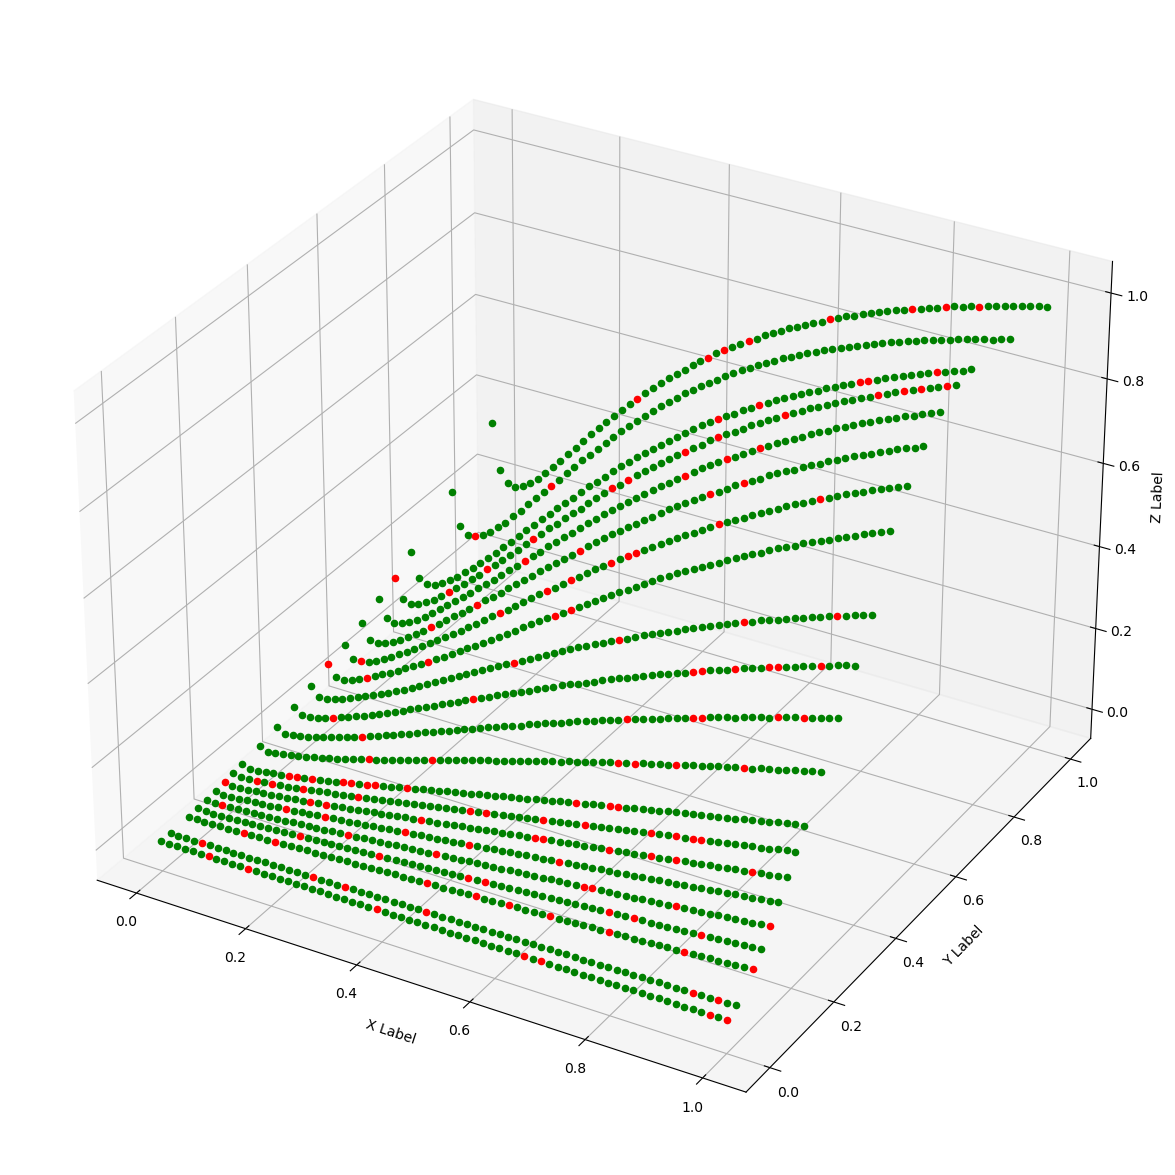

In [31]:
train_xy, train_z, test_xy, test_z = get_train_and_test_random (temp_values, vib_values, \
    df, 0.1)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for i in range(train_z.shape[0]):
    x = train_xy[i,0]
    y = train_xy[i,1]
    z = train_z[i]
    ax.scatter(x, y, z, marker="o", color="g")

for i in range(test_z.shape[0]):
    x = test_xy[i,0]
    y = test_xy[i,1]
    z = test_z[i]
    ax.scatter(x, y, z, marker="o", color="r")

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.gcf().set_size_inches(20, 15)

plt.show()

In [32]:
modelr = build_model()

history = None
nepochs = 100
history = modelr.fit(train_xy, train_z, epochs=nepochs, verbose=0)

z_pred = modelr.predict(train_xy)

trainmse = 0.0
cont = 0.0
for i in range(train_z.shape[0]):
    x = train_xy[i,0]
    y = train_xy[i,1]
    z = train_z[i]
    zpred = z_pred[i]
    
    trainmse += (zpred-z)**2
    cont += 1.0

    print("Train, %10.7f , %10.7f , %10.7f , %10.7f"%(z, y, z, zpred))

trainmse = trainmse/cont

z_pred = model.predict(test_xy)

mse = 0.0
cont = 0.0
for i in range(test_z.shape[0]):
    x = test_xy[i,0]
    y = test_xy[i,1]
    z = test_z[i]
    zpred = z_pred[i]
    
    mse += (zpred-z)**2
    cont += 1.0

    print("Test, %10.7f , %10.7f , %10.7f , %10.7f"%(z, y, z, zpred))

mse = mse/cont

print("Removed random values  MSE ", mse, " , TrainMSE ,", trainmse, flush=True)

42/42 [==============================] - 0s 5ms/step
Train,  0.0000722 ,  0.0000000 ,  0.0000722 ,  0.0025326
Train,  0.0008899 ,  0.0256410 ,  0.0008899 ,  0.0039828
Train,  0.0035298 ,  0.0769231 ,  0.0035298 ,  0.0086994
Train,  0.0051226 ,  0.1025641 ,  0.0051226 ,  0.0115419
Train,  0.0076712 ,  0.1282051 ,  0.0076712 ,  0.0142552
Train,  0.0104322 ,  0.1538462 ,  0.0104322 ,  0.0165933
Train,  0.0175257 ,  0.2051282 ,  0.0175257 ,  0.0272128
Train,  0.0215609 ,  0.2307692 ,  0.0215609 ,  0.0318553
Train,  0.0289942 ,  0.2820513 ,  0.0289942 ,  0.0407070
Train,  0.0396133 ,  0.3333333 ,  0.0396133 ,  0.0496533
Train,  0.0546923 ,  0.3846154 ,  0.0546923 ,  0.0608527
Train,  0.0699838 ,  0.4358974 ,  0.0699838 ,  0.0730686
Train,  0.1016285 ,  0.5384615 ,  0.1016285 ,  0.1046275
Train,  0.1209552 ,  0.5897436 ,  0.1209552 ,  0.1237020
Train,  0.1451666 ,  0.6410256 ,  0.1451666 ,  0.1423648
Train,  0.1952885 ,  0.7435897 ,  0.1952885 ,  0.1741479
Train,  0.2609143 ,  0.8717949 ,  0

In [33]:
# test new model
import tensorflow.keras.optimizers as tko
import tensorflow.keras.activations as tka
import tensorflow.keras.losses as tkl
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

def build_activation_function(af):
    if af.lower() == 'none':
        return None
    exp_af = 'lambda _ : tka.' + af
    return eval(exp_af)(None)

def build_optimizer(optimizer):
    opt_init = optimizer
    exp_po = 'lambda _ : tko.' + opt_init
    optimizer = eval(exp_po)(None)
    return optimizer

def build_loss(loss):
    exp_loss = 'lambda _ : tkl.' + loss
    return eval(exp_loss)(None)

def build_new_model(hidden_layers_layout, activation_functions):
    inputs = Input(shape=(2,))
    hidden = inputs
    for i in range(0, len(hidden_layers_layout)):
        hidden = Dense(hidden_layers_layout[i], activation=build_activation_function(activation_functions[i]))(hidden)
    outputs = Dense(1)(hidden)
    model = Model(inputs=inputs, outputs=outputs)
   
    return model


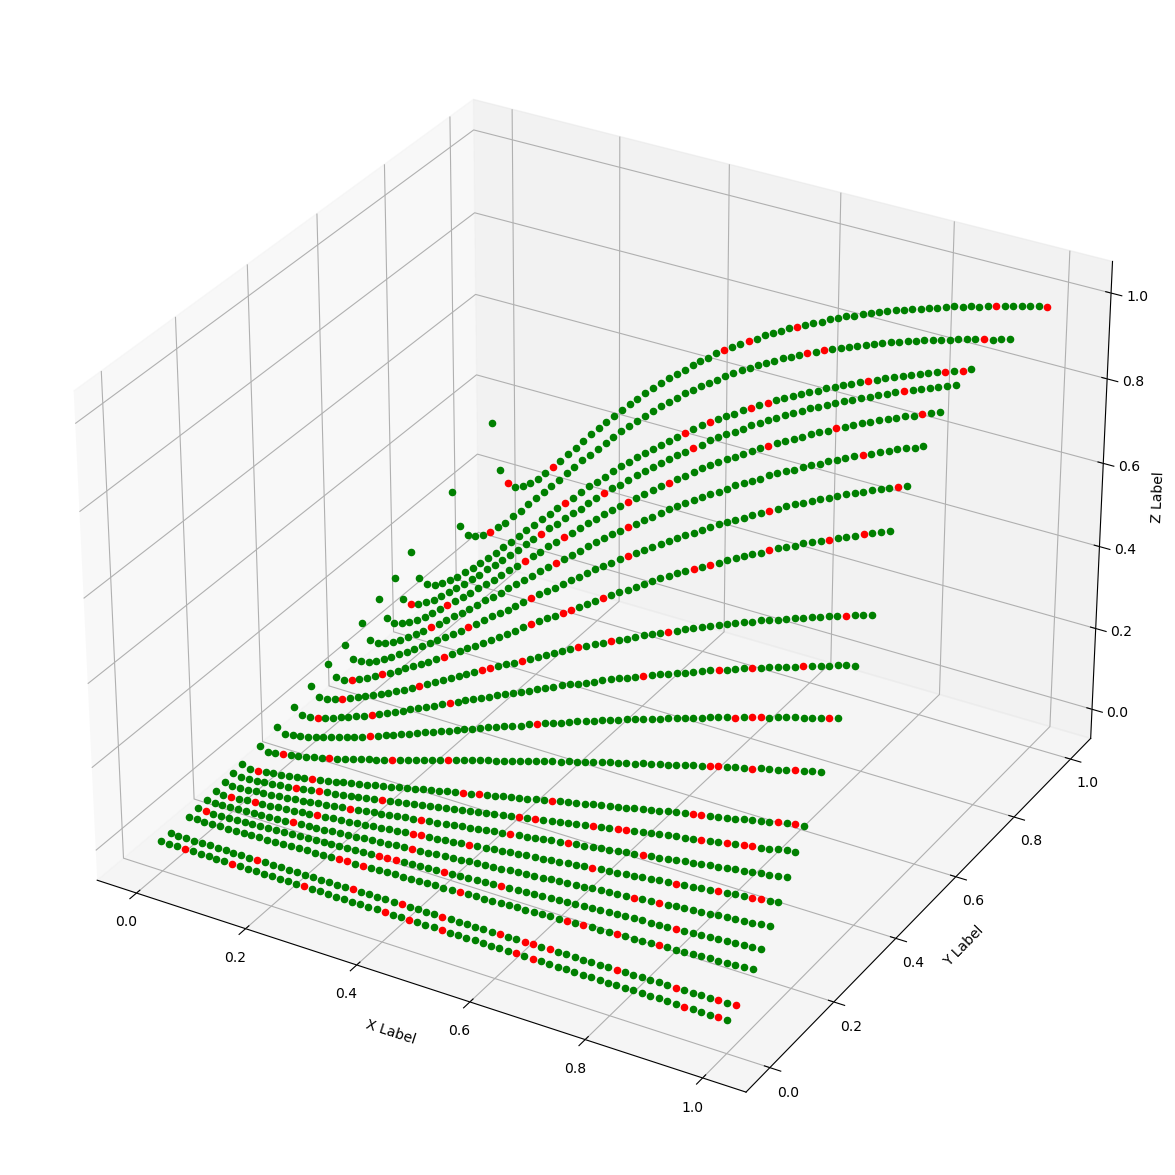

In [34]:
train_xy, train_z, test_xy, test_z = get_train_and_test_random (temp_values, vib_values, \
    df, 0.1)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for i in range(train_z.shape[0]):
    x = train_xy[i,0]
    y = train_xy[i,1]
    z = train_z[i]
    ax.scatter(x, y, z, marker="o", color="g")

for i in range(test_z.shape[0]):
    x = test_xy[i,0]
    y = test_xy[i,1]
    z = test_z[i]
    ax.scatter(x, y, z, marker="o", color="r")

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.gcf().set_size_inches(20, 15)

plt.show()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_636 (Dense)           (None, 100)               300       
                                                                 
 dense_637 (Dense)           (None, 100)               10100     
                                                                 
 dense_638 (Dense)           (None, 1)                 101       
                                                                 
Total params: 10,501
Trainable params: 10,501
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
27/27 [==============================] - 1s 8ms/step - loss: 0.0599
Epoch 2/10
27/27 [==============================] - 0s 6ms/step - loss: 0.0196
Epoch 3/10
27/27 [===========

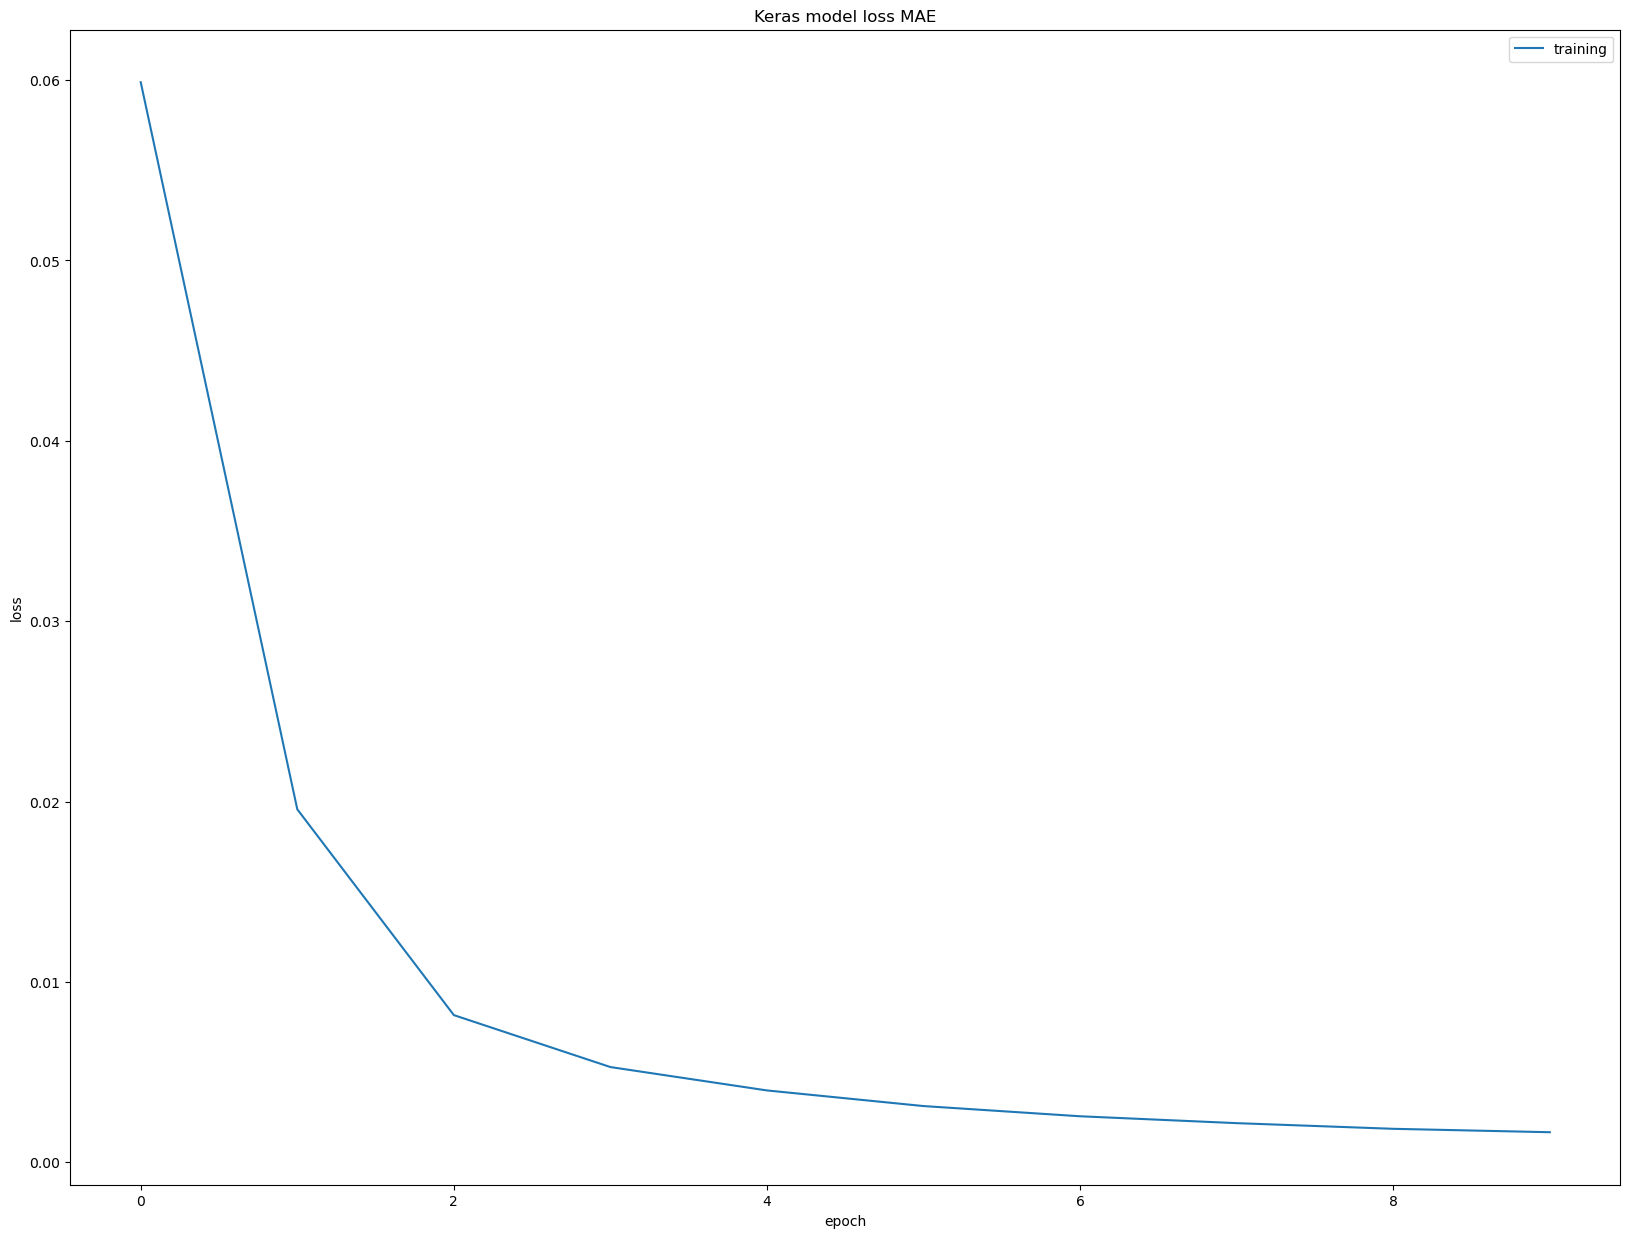

41/41 [==============================] - 0s 5ms/step
Train,  0.0000722 ,  0.0000000 ,  0.0000722 ,  0.0025326
Train,  0.0008899 ,  0.0256410 ,  0.0008899 ,  0.0039828
Train,  0.0035298 ,  0.0769231 ,  0.0035298 ,  0.0086994
Train,  0.0051226 ,  0.1025641 ,  0.0051226 ,  0.0115419
Train,  0.0076712 ,  0.1282051 ,  0.0076712 ,  0.0142552
Train,  0.0104322 ,  0.1538462 ,  0.0104322 ,  0.0165933
Train,  0.0143187 ,  0.1794872 ,  0.0143187 ,  0.0193280
Train,  0.0175257 ,  0.2051282 ,  0.0175257 ,  0.0272128
Train,  0.0215609 ,  0.2307692 ,  0.0215609 ,  0.0318553
Train,  0.0289942 ,  0.2820513 ,  0.0289942 ,  0.0407070
Train,  0.0396133 ,  0.3333333 ,  0.0396133 ,  0.0496533
Train,  0.0546923 ,  0.3846154 ,  0.0546923 ,  0.0608527
Train,  0.0699838 ,  0.4358974 ,  0.0699838 ,  0.0730686
Train,  0.0888857 ,  0.4871795 ,  0.0888857 ,  0.0877227
Train,  0.1016285 ,  0.5384615 ,  0.1016285 ,  0.1046276
Train,  0.1209552 ,  0.5897436 ,  0.1209552 ,  0.1237020
Train,  0.1451666 ,  0.6410256 ,  0

In [37]:
hidden_layers_layout = [100, 100]
activation_functions = ["relu", "relu"]
epochs = 10
batch_size = 50
inoptimizer = "SGD(decay=1e-6, momentum=0.9, nesterov=True)"
loss = 'MeanSquaredError()'

model = build_new_model(hidden_layers_layout, activation_functions)
optimizer = build_optimizer(inoptimizer)
model.compile(loss=build_loss(loss), optimizer=optimizer)
model.summary()

history = model.fit(train_xy, train_z, epochs=epochs, batch_size=batch_size, verbose=1)

plt.title('Keras model loss MAE')
plt.plot(history.history['loss'])
if usevalidation:
    plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.gcf().set_size_inches(20, 15)

plt.show()

z_pred = modelr.predict(train_xy)

trainmse = 0.0
cont = 0.0
for i in range(train_z.shape[0]):
    x = train_xy[i,0]
    y = train_xy[i,1]
    z = train_z[i]
    zpred = z_pred[i]
    
    trainmse += (zpred-z)**2
    cont += 1.0

    print("Train, %10.7f , %10.7f , %10.7f , %10.7f"%(z, y, z, zpred))

trainmse = trainmse/cont

z_pred = model.predict(test_xy)

mse = 0.0
cont = 0.0
for i in range(test_z.shape[0]):
    x = test_xy[i,0]
    y = test_xy[i,1]
    z = test_z[i]
    zpred = z_pred[i]
    
    mse += (zpred-z)**2
    cont += 1.0

    print("Test, %10.7f , %10.7f , %10.7f , %10.7f"%(z, y, z, zpred))

mse = mse/cont

print("Removed random values  MSE ", mse, " , TrainMSE ,", trainmse, flush=True)
